In [21]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv

In [22]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [23]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = np.sqrt(2)

In [24]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 25)]

In [25]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [26]:
c = lambda x, y: (x - y)**2

In [27]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [44]:
# p-norm
p = 2.
sinkhorn_runner = skern.get_pnorm_regularized_runner(p, c)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


epsilons = [0.1, 0.5, 1.0]
delta = 0.01

distribution_outputs_quadratic = {}
for epsilon in epsilons:
    print(f"Running Quadratic, epsilon = {epsilon}")
    pi_p, f_p, g_p = sinkhorn_runner.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_quadratic[epsilon] = (pi_p, f_p, g_p)

print("Done with quadratic.")

distribution_outputs_entropic = {}
for epsilon in epsilons:
    print(f"Running Entropic, epsilon = {epsilon}")
    pi_p, f_p, g_p = pi_e, f_e, g_e = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    distribution_outputs_entropic[epsilon] = (pi_p, f_p, g_p)

print("Done with entropic.")

Running Quadratic, epsilon = 0.1
Running Quadratic, epsilon = 0.5
Running Quadratic, epsilon = 1.0
Done with quadratic.
Running Entropic, epsilon = 0.1
Running Entropic, epsilon = 0.5
Running Entropic, epsilon = 1.0
Done with entropic.


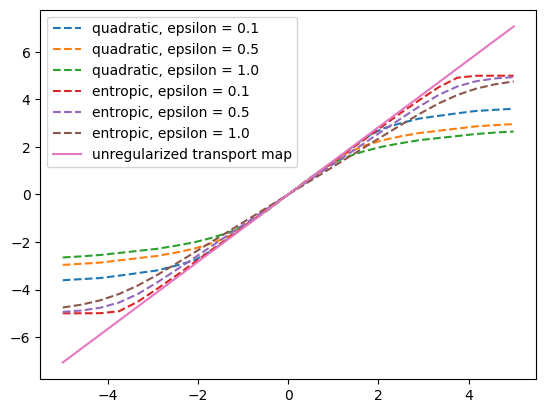

In [46]:
# calculate conditional maps
conditional_maps_quadratic = {}
for epsilon in epsilons:
    (pi_p, _, _) = distribution_outputs_quadratic[epsilon]
    conditional_map = pi_p.calculate_conditional_map()
    conditional_maps_quadratic[epsilon] = conditional_map
conditional_maps_entropic = {}
for epsilon in epsilons:
    if epsilon in distribution_outputs_entropic:
        (pi_p, _, _) = distribution_outputs_entropic[epsilon]
        conditional_map = pi_p.calculate_conditional_map()
        conditional_maps_entropic[epsilon] = conditional_map
xs = sorted(list(f_p.keys()))

plt.figure()
for epsilon in epsilons:
    conditional_map = conditional_maps_quadratic[epsilon]
    plt.plot(xs, [conditional_map[x] for x in xs], linestyle = 'dashed', label = f'quadratic, epsilon = {epsilon}')
for epsilon in epsilons:
    if epsilon in conditional_maps_entropic:
        conditional_map = conditional_maps_entropic[epsilon]
        plt.plot(xs, [conditional_map[x] for x in xs], linestyle = 'dashed', label = f'entropic, epsilon = {epsilon}')
plt.plot(xs, [unregularized_transport_map(x) for x in xs], linestyle = 'solid', label = 'unregularized transport map')
plt.legend()
plt.show()